In [1]:
from numba import jit, prange
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
@jit(nopython=True, parallel=True, fastmath=True)
def mandelbrot_smooth_optimized(width, height, x_min, x_max, y_min, y_max, max_iter):
    result = np.zeros((height, width), dtype=np.float32)

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height

    log2 = math.log(2.0)

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2
                n += 1

            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n
    return result

def equalize_histogram(data):
    """Apply histogram equalization to a 2D numpy array."""
    hist, bins = np.histogram(data.flatten(), bins=512, density=True)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = cdf / cdf[-1]  # normalize to [0,1]

    # Use linear interpolation of cdf to find new pixel values
    data_flat = np.interp(data.flatten(), bins[:-1], cdf)
    return data_flat.reshape(data.shape)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


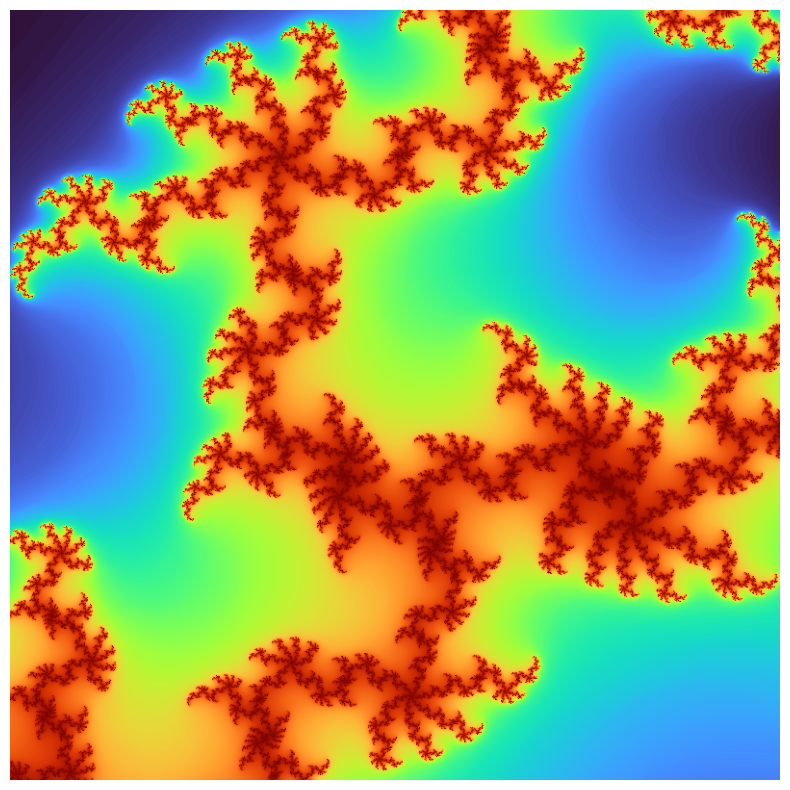

CPU times: user 1.42 s, sys: 424 ms, total: 1.84 s
Wall time: 593 ms


In [3]:
%%time

# Parameters
res = 800
width, height = res, res
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
zoom = 	78125
delta = 2 / zoom
center = 0.42884,-0.231345
x_min, y_min = center[0] - delta, center[1] - delta
x_max, y_max = center[0] + delta, center[1] + delta
max_iter = 10000

# Compute
mandelbrot_image = mandelbrot_smooth_optimized(width, height, x_min, x_max, y_min, y_max, max_iter)

# Equalize smooth values
mandelbrot_eq = equalize_histogram(mandelbrot_image)

# Plot with smooth color gradient
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_eq, extent=(x_min, x_max, y_min, y_max), cmap='turbo')
plt.axis('off')
plt.show()


In [4]:
from numba import jit, prange
import numpy as np
import math

@jit(nopython=True, parallel=True, fastmath=True)
def mandelbrot_smooth_with_grid_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter,
    grid_spacing
):
    result = np.zeros((height, width), dtype=np.float32)
    trap = np.full((height, width), np.inf, dtype=np.float32)  # min distance trap

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height
    log2 = math.log(2.0)

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0
            min_dist = 1e10

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2

                # Distance to nearest vertical grid line
                dx_mod = zr % grid_spacing
                dx = min(dx_mod, grid_spacing - dx_mod)

                # Distance to nearest horizontal grid line
                dy_mod = zi % grid_spacing
                dy = min(dy_mod, grid_spacing - dy_mod)

                dist = min(dx, dy)

                if dist < min_dist:
                    min_dist = dist

                n += 1

            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n

            trap[y, x] = min_dist

    return result, trap


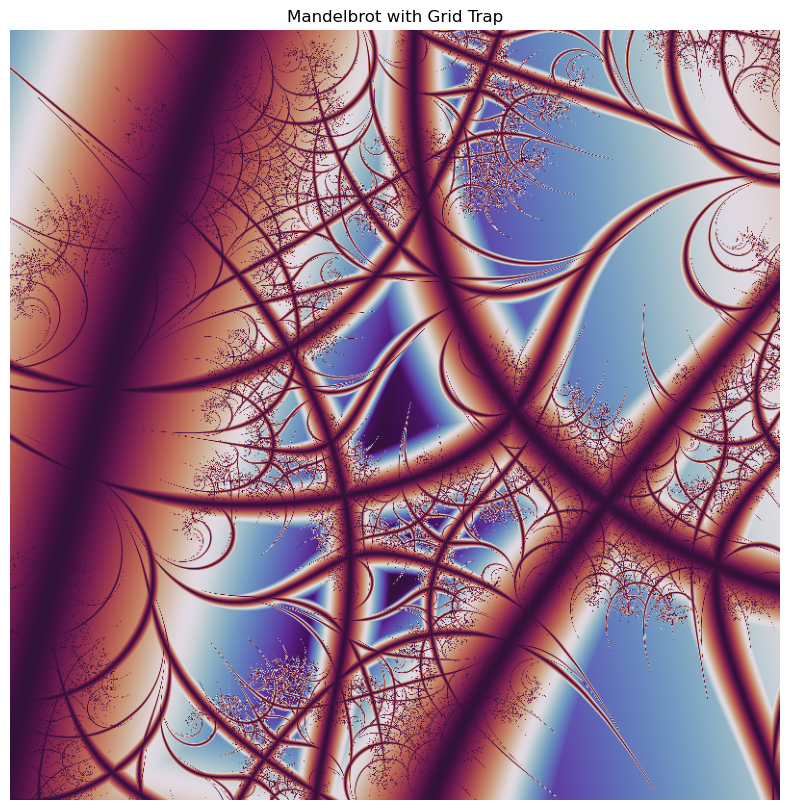

CPU times: user 1.55 s, sys: 402 ms, total: 1.95 s
Wall time: 536 ms


In [5]:
%%time

width, height = 800, 800
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iter = 256

res = 800
width, height = res, res
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
zoom = 	78125
delta = 2 / zoom
center = 0.42884,-0.231345
x_min, y_min = center[0] - delta, center[1] - delta
x_max, y_max = center[0] + delta, center[1] + delta
max_iter = 256

grid_spacing = 10 # smaller for finer grids

mandelbrot_img, grid_trap = mandelbrot_smooth_with_grid_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter, grid_spacing
)

# Normalize for display
img_norm = (mandelbrot_img - mandelbrot_img.min()) / (mandelbrot_img.max() - mandelbrot_img.min())
trap_norm = 1 - (grid_trap - grid_trap.min()) / (grid_trap.max() - grid_trap.min())

blended = img_norm * trap_norm

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(trap_norm, cmap='twilight_shifted', extent=(x_min, x_max, y_min, y_max))
plt.title("Mandelbrot with Grid Trap")
plt.axis('off')
plt.show()


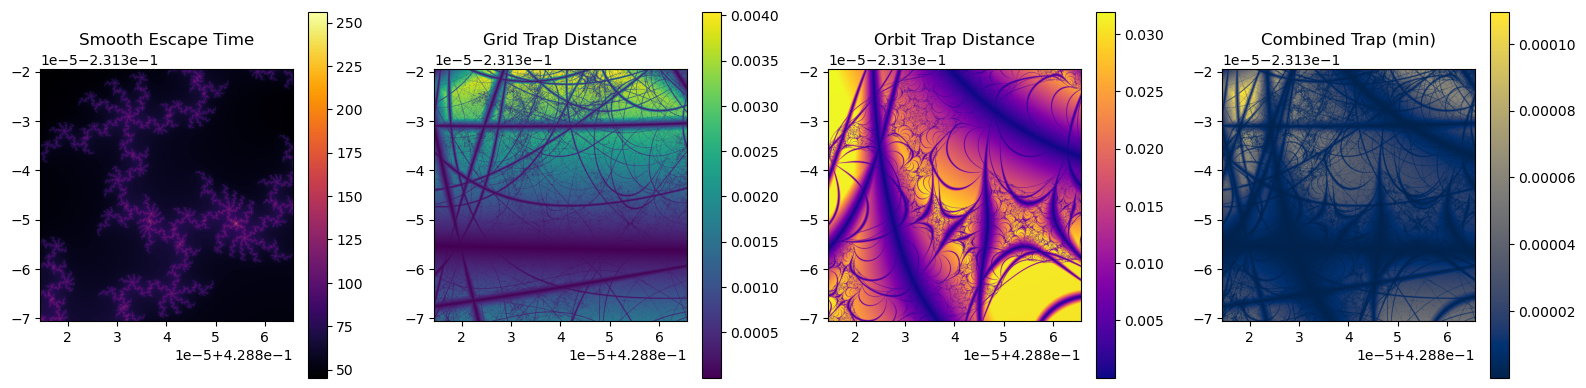

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
import math

@jit(nopython=True, parallel=True, fastmath=True)
def mandelbrot_grid_orbit_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter,
    grid_spacing, orbit_trap_center, orbit_trap_radius
):
    result = np.zeros((height, width), dtype=np.float32)
    grid_trap = np.full((height, width), np.inf, dtype=np.float32)
    orbit_trap = np.full((height, width), np.inf, dtype=np.float32)

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height
    log2 = math.log(2.0)

    cx, cy = orbit_trap_center

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0
            min_grid_dist = 1e10
            min_orbit_dist = 1e10

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2

                # Grid trap: distance to nearest grid line
                dx_mod = zr % grid_spacing
                dx = min(dx_mod, grid_spacing - dx_mod)
                dy_mod = zi % grid_spacing
                dy = min(dy_mod, grid_spacing - dy_mod)
                grid_dist = min(dx, dy)
                if grid_dist < min_grid_dist:
                    min_grid_dist = grid_dist

                # Orbit trap: distance to defined center point
                orbit_dx = zr - cx
                orbit_dy = zi - cy
                orbit_dist = math.sqrt(orbit_dx**2 + orbit_dy**2) - orbit_trap_radius
                orbit_dist = abs(orbit_dist)  # Treat as ring trap
                if orbit_dist < min_orbit_dist:
                    min_orbit_dist = orbit_dist

                n += 1

            # Smooth coloring
            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n

            grid_trap[y, x] = min_grid_dist
            orbit_trap[y, x] = min_orbit_dist

    return result, grid_trap, orbit_trap

# Parameters
width, height = 800, 800
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iter = 500
grid_spacing = 0.3
orbit_trap_center = (0.0, 0.0)
orbit_trap_radius = 1.1  # Ring orbit trap

res = 800
width, height = res, res
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
zoom = 	78125
delta = 2 / zoom
center = 0.42884,-0.231345
x_min, y_min = center[0] - delta, center[1] - delta
x_max, y_max = center[0] + delta, center[1] + delta
max_iter = 256

# Run
result, grid_trap, orbit_trap = mandelbrot_grid_orbit_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter,
    grid_spacing, orbit_trap_center, orbit_trap_radius
)

# Combine traps: take the smaller distance of the two
combined_trap = grid_trap * orbit_trap

# Plot everything
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(result, cmap='inferno', extent=[x_min, x_max, y_min, y_max])
plt.title("Smooth Escape Time")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(grid_trap, cmap='viridis', extent=[x_min, x_max, y_min, y_max])
plt.title("Grid Trap Distance")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(orbit_trap, cmap='plasma', extent=[x_min, x_max, y_min, y_max])
plt.title("Orbit Trap Distance")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(combined_trap, cmap='cividis', extent=[x_min, x_max, y_min, y_max])
plt.title("Combined Trap (min)")
plt.colorbar()

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from numba import jit, prange
import math

@jit(nopython=True, parallel=True, fastmath=True)
def mandelbrot_cross_and_point_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter,
    trap_point=(0.0, 0.0), trap_radius=0.0
):
    result = np.zeros((height, width), dtype=np.float32)
    cross_trap = np.full((height, width), np.inf, dtype=np.float32)
    point_trap = np.full((height, width), np.inf, dtype=np.float32)

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height
    log2 = math.log(2.0)

    px, py = trap_point

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0
            min_cross = 1e10
            min_point = 1e10

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2

                # Cross trap: distance to real or imaginary axis
                cross_dist = min(abs(zr), abs(zi))
                if cross_dist < min_cross:
                    min_cross = cross_dist

                # Point trap: distance to a center point
                dx = zr - px
                dy = zi - py
                point_dist = math.sqrt(dx * dx + dy * dy) - trap_radius
                point_dist = abs(point_dist)
                if point_dist < min_point:
                    min_point = point_dist

                n += 1

            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n

            cross_trap[y, x] = min_cross
            point_trap[y, x] = min_point

    return result, cross_trap, point_trap


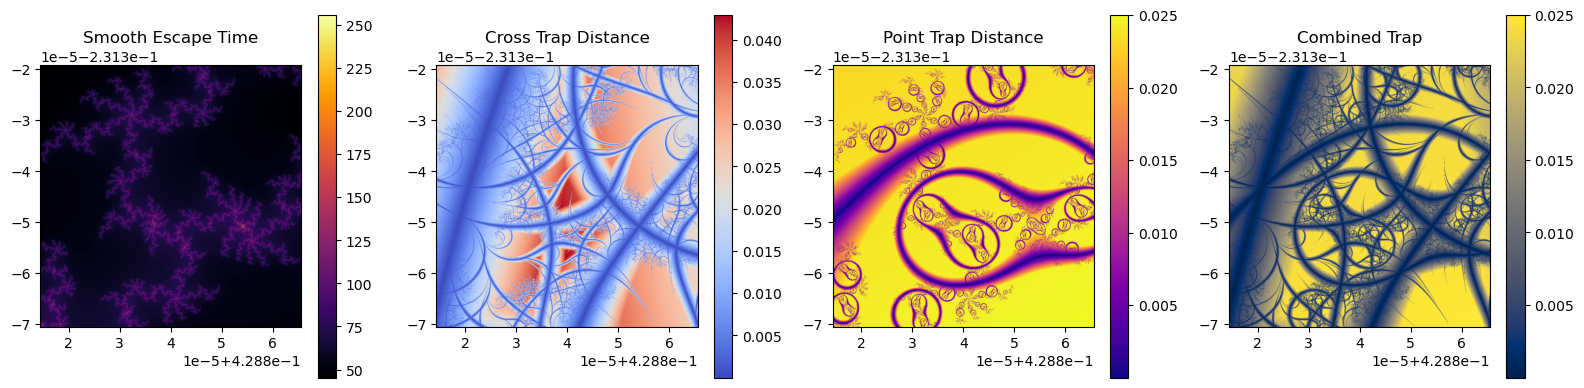

In [18]:
import matplotlib.pyplot as plt

# Run the computation
width, height = 800, 800
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iter = 500
trap_point = (0.0, 0.0)
trap_radius = 0.2  # Ring-shaped trap

res = 800
width, height = res, res
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
zoom = 	78125
delta = 2 / zoom
center = 0.42884,-0.231345
x_min, y_min = center[0] - delta, center[1] - delta
x_max, y_max = center[0] + delta, center[1] + delta
max_iter = 256

result, cross_trap, point_trap = mandelbrot_cross_and_point_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter,
    trap_point, trap_radius
)

# Combine both traps
combined_trap = np.minimum(cross_trap, point_trap)

# Plot all
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(result, cmap='inferno', extent=[x_min, x_max, y_min, y_max])
plt.title("Smooth Escape Time")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(cross_trap, cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
plt.title("Cross Trap Distance")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(point_trap, cmap='plasma', extent=[x_min, x_max, y_min, y_max])
plt.title("Point Trap Distance")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(combined_trap, cmap='cividis', extent=[x_min, x_max, y_min, y_max])
plt.title("Combined Trap")
plt.colorbar()

plt.tight_layout()
plt.show()
